# Intro to Computer Vision

Objectives:

  * Gain a firm sense of how machines "see" images
  * Explore the intuition underlying object detection algorithms
  * Learn how to use open-source tools to evaluate how an open-source model performs w.r.t the task of detecting licence plates in images
  * Consider the ethics of applying computer vision tools and techniques to a given task

# An overview of how a computer looks at an image, and how to use that for further processing

In [ ]:
# Imports!
import matplotlib.pyplot as plt

import skimage.io as io

import numpy as np
import pandas as pd

## First, and example of how a computer breaks an image down

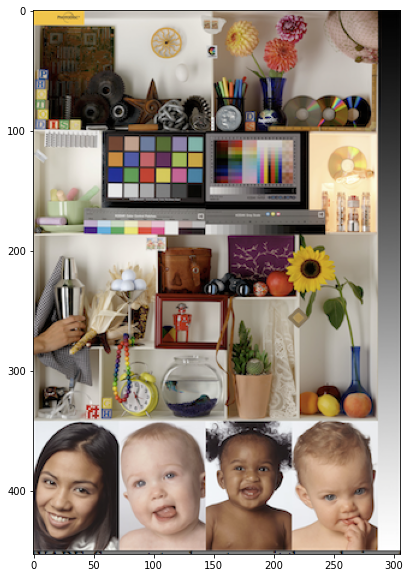

In [ ]:
# Read and Display 

img = io.imread('http://www.colorwiki.com/images/0/0a/Photodisc.png')
plt.figure(figsize=(10,10))
plt.imshow(img);

## How the computer looks at it

In [ ]:
# First, the shape of the photo

print(f'There are {img.shape[0]} pixels in the vertical channel')
print(f'There are {img.shape[1]} pixels in the horizontal')
print(f'There are {img.shape[2]} channels in the "z-axis"')

There are 453 pixels in the vertical channel
There are 306 pixels in the horizontal
There are 3 channels in the "z-axis"


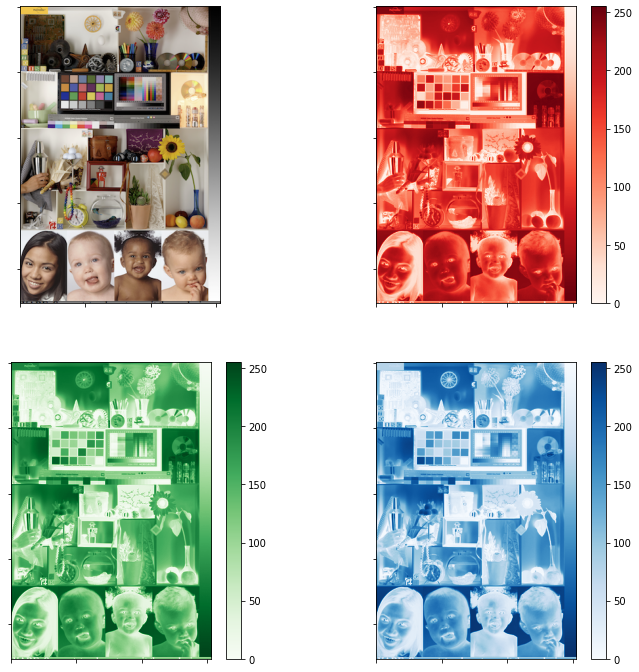

In [ ]:
# Split into color channels
red = img[:, :, 0]
green = img[:, :, 1]
blue = img[:, :, 2]

# Plot
fig, axs = plt.subplots(2,2, figsize=(12,12))


# Normal Image
cax_00 = axs[0,0].imshow(img)
axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # kill xlabels
axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # kill ylabels

# Red Channel
cax_01 = axs[0,1].imshow(red, cmap='Reds')
fig.colorbar(cax_01, ax=axs[0,1])
axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())


# Green Channel
cax_10 = axs[1,0].imshow(green, cmap='Greens')
fig.colorbar(cax_10, ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())

# Blue Channel
cax_11 = axs[1,1].imshow(blue, cmap='Blues')
fig.colorbar(cax_11, ax=axs[1,1])
axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())

plt.show();

### Some basic information about the image

In [ ]:
# Size of one of the channels

red.shape

(453, 306)

In [ ]:
# Example of the data

red[0]

array([244, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242,
       242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242,
       241, 244, 247, 248, 248, 244, 240, 242, 242, 242, 242, 242, 242,
       242, 241, 244, 228, 197, 201, 201, 201, 201, 201, 201, 202, 202,
       201, 200, 200, 201, 202, 201, 201, 201, 200, 201, 201, 202, 201,
       202, 201, 201, 202, 203, 203, 203, 205, 203, 203, 203, 203, 203,
       203, 203, 202, 203, 203, 202, 201, 201, 201, 201, 202, 202, 202,
       203, 201, 202, 202, 202, 202, 202, 201, 201, 201, 200, 200, 201,
       202, 202, 202, 201, 201, 201, 200, 201, 200, 199, 199, 200, 201,
       201, 200, 199, 200, 199, 199, 199, 199, 199, 199, 200, 200, 201,
       201, 201, 202, 202, 202, 200, 201, 201, 202, 202, 202, 202, 203,
       203, 202, 202, 203, 202, 198, 196, 196, 198, 199, 199, 199, 198,
       197, 198, 199, 199, 199, 199, 198, 197, 198, 198, 198, 197, 197,
       198, 197, 197, 198, 197, 197, 197, 196, 195, 196, 196, 19

### A (very) simple filter

Using linear algebra, we can transform the matrix

In [ ]:
red = red *1.2
blue = blue *1.4
green = green * 1.6

In [ ]:
# re-assign to the proper channel in the original image

img[:, :, 0] = red
img[:, :, 1] = green
img[:, :, 2] = blue

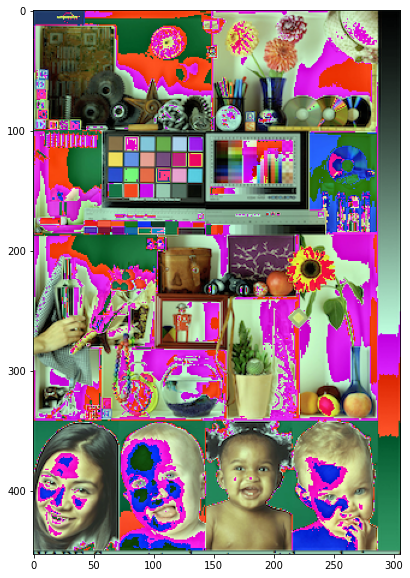

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img)

# Using OpenCV for Noise Reduction and Edge Detection

Since edge detection is susceptible to noise in the image, first step is to remove the noise in the image with a Gaussian filter. 

The smoothened image is then filtered in both horizontal and vertical direction to get first derivative in horizontal direction (Gx) and vertical direction (Gy). From these two images, we can find edge gradient and direction for each pixel.

Gradient direction is always perpendicular to edges. It is rounded to one of four angles representing vertical, horizontal and two diagonal directions.

After getting gradient magnitude and direction, a full scan of image is done to remove any unwanted pixels which may not constitute the edge. For this, at every pixel, the pixel is evaluated to see if it is a local maximum in its neighborhood in the direction of gradient. Check the image below:

![](https://docs.opencv.org/4.x/nms.jpg)

Point A is on the edge (in the vertical direction). Gradient direction is normal to the edge. Point B and C are in gradient directions. So point A is checked with point B and C to see if it forms a local maximum. If so, it is considered for next stage, otherwise, it is suppressed (put to zero).

In short, the result you get is a binary image with "thin edges".

A processing stage known as *Hysteresis Thresholding* decides which are all edges are really edges and which are not. For this, we need two threshold values, `minVal` and `maxVal`. Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to "sure-edge" pixels, they are considered to be part of edges. Otherwise, they are also discarded. See the image below:

![](https://docs.opencv.org/4.x/hysteresis.jpg)

The edge A is above the maxVal, so considered as "sure-edge". Although edge C is below maxVal, it is connected to edge A, so that also considered as valid edge and we get that full curve. But edge B, although it is above minVal and is in same region as that of edge C, it is not connected to any "sure-edge", so that is discarded. So it is very important that we have to select minVal and maxVal accordingly to get the correct result.

This stage also removes small pixels noises on the assumption that edges are long lines.

So what we finally get is strong edges in the image.

In [ ]:
!pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%bash

wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye_tree_eyeglasses.xml
wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml
wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_smile.xml
wget https://raw.githubusercontent.com/flatiron-school/DS-Deloitte-07062022/main/archived/intensive/images/nick.jpeg

--2022-11-18 16:32:21--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye_tree_eyeglasses.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 601661 (588K) [text/plain]
Saving to: ‘haarcascade_eye_tree_eyeglasses.xml.1’

     0K .......... .......... .......... .......... ..........  8% 3.99M 0s
    50K .......... .......... .......... .......... .......... 17% 5.61M 0s
   100K .......... .......... .......... .......... .......... 25% 23.8M 0s
   150K .......... .......... .......... .......... .......... 34% 24.1M 0s
   200K .......... .......... .......... .......... .......... 42% 7.42M 0s
   250K .......... .......... .......... .......... .......... 51% 29.0M 0s
   300K .......... .......... .......... ..........

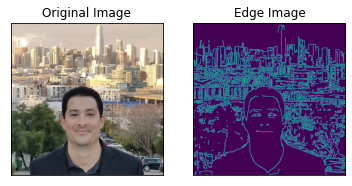

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('nick.jpeg')
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

img_blurred = cv.GaussianBlur(img_gray, (5, 5), 0)
edges = cv.Canny(img, 100, 200)

plt.subplot(121), plt.imshow(img_rgb)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Using OpenCV for Face Detection

Here we will take a look at OpenCV's face detection capabilties. Initially, such an algorithm needs a lot of positive images (images of faces) and negative images (images without faces) to train the classifier. Then we need to extract features from it. For this, Haar features (shown in the image below) are used. They are just like a convolutional kernel. Each feature is a single value obtained by subtracting sum of pixels under the white rectangle from sum of pixels under the black rectangle.

![](https://docs.opencv.org/3.4/haar_features.jpg)

Now, all possible sizes and locations of each kernel are used to calculate lots of features. For example, a 24x24 window results in over 160,000 features! For each feature calculation, we need to find the sum of the pixels under white and black rectangles. To solve this, they introduced the integral image. However large your image, it reduces the calculations for a given pixel to an operation involving just four pixels. 

But among all these features we calculated, most of them are irrelevant. For example, consider the image below. The top row shows two good features. The first feature selected seems to focus on the property that the region of the eyes is often darker than the region of the nose and cheeks. The second feature selected relies on the property that the eyes are darker than the bridge of the nose. But the same windows applied to cheeks or any other place is irrelevant. So how do we select the best features out of 160,000+ features? It is achieved by Adaboost. According to the scikit-learn docs, Adaboost is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset, where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

![](https://docs.opencv.org/3.4/haar.png)

For this, we apply each and every feature on all the training images. For each feature, it finds the best threshold which will classify the faces to positive and negative. Obviously, there will be errors or misclassifications. We select the features with minimum error rate, which means they are the features that most accurately classify the face and non-face images. (The process is not as simple as this. Each image is given an equal weight in the beginning. After each classification, weights of misclassified images are increased. Then the same process is done. New error rates are calculated. Also new weights. The process is continued until the required accuracy or error rate is achieved or the required number of features are found).

The final classifier is a weighted sum of these weak classifiers. It is called weak because it alone can't classify the image, but together with others forms a strong classifier. The final setup had around 6000 features.

So now you take an image. Take each 24x24 window. Apply 6000 features to it...seems like a lot.

In an image, most of the image is non-face region. So it is a better idea to have a simple method to check if a window is not a face region. If it is not, discard it in a single shot, and don't process it again. Instead, focus on regions where there can be a face. This way, we spend more time checking possible face regions.

For this, researchers introduced the concept of *Cascade of Classifiers*. Instead of applying all 6000 features on a window, the features are grouped into different stages of classifiers and applied one-by-one. (Normally the first few stages will contain very many fewer features). If a window fails the first stage, discard it. We don't consider the remaining features on it. If it passes, apply the second stage of features and continue the process. The window which passes all stages is a face region. How is that plan!

The original researchers' detector had 6000+ features with 38 stages with 1, 10, 25, 25 and 50 features in the first five stages. (The two features in the above image are actually obtained as the best two features from Adaboost). According to the researchers, on average of 10 features out of 6000+ are evaluated per sub-window.

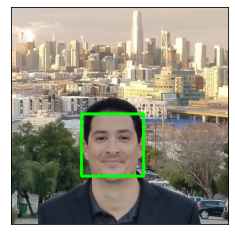

In [ ]:
import cv2
from matplotlib import pyplot as plt

# OpenCV opens images as BRG
# but we want it as RGB We'll
# also need a grayscale version

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

classifier = cv.CascadeClassifier('haarcascade_frontalface_alt.xml')

detected_objects = classifier.detectMultiScale(img_gray,
                                    minSize =(20, 20))

amount_found = len(detected_objects)

if amount_found != 0:

    for (x, y, width, height) in detected_objects:

        cv2.rectangle(img_rgb, (x, y),
                     (x + height, y + width),
                     (0, 255, 0), 5)

# Creates the environment of
# the picture and shows it

plt.subplot(1, 1, 1), plt.xticks([]), plt.yticks([])
plt.imshow(img_rgb)
plt.show()

### This is ultimately what we're really after:

In [ ]:
detected_objects

array([[165, 253, 146, 146]], dtype=int32)

#### Let's see how Facebook's open-sourced Detectron2 model performs w.r.t the task of detecting licence plates after being fine-tuned on a dataset of license plate images! 🤯

<a href="https://colab.research.google.com/drive/1LyI9UMdW6kQqFXdi7yPBoBSmFJ4b0XUq?usp=sharing#offline=true&sandboxMode=true">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Sources

The rbg separation was example was adapted from [this stackoverflow](https://stackoverflow.com/questions/39885178/how-can-i-see-the-rgb-channels-of-a-given-image-with-python) article

The Canny edge detection material was adapted from [the OpenCV docs](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html)

The Cascade face detection material was also adapted from [the OpenCV docs](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html)